In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path
from src import Encoder, Decoder
import numpy as np
import matplotlib.pyplot as plt
import librosa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
encoder = Encoder(modulation='bpsk')

encoder.encode(Path('test.txt'), Path('text.txt.wav'), sample_rate=16000)


Encoded test.txt into text.txt.wav


In [41]:
decoder = Decoder(modulation='bpsk')

decoder.decode_file(Path('text.txt.wav'))

KeyError: np.complex128(81287.09881218913-1.928457393773897e-13j)

[autoreload of src.encoder failed: Traceback (most recent call last):
  File "D:\Projects\Python\DataTransmission\venv\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "D:\Projects\Python\DataTransmission\venv\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\rudko\AppData\Local\Programs\Python\Python311\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "D:\Projects\Python\DataTransmission\src\encoder.py", line 7, in <module>
    from psk_modulation import QPSK_Modulation, Modulation, BPSK_Modulation, PSK_Modulation
ModuleNotFoundError: No module named 'psk_modulati

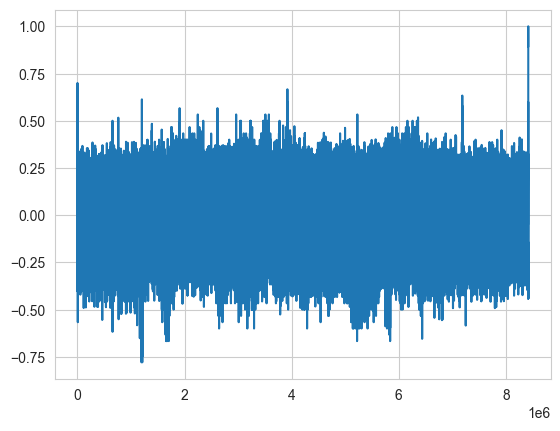

In [42]:
y, sample_rate = librosa.load(Path('test.png.wav'), sr=44100)

plt.plot(y)

Sample rate:  16000


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

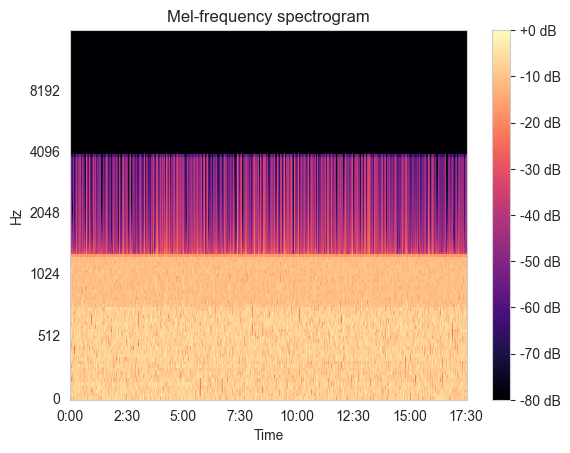

In [10]:
fig, ax = plt.subplots()
# y, sample_rate = librosa.load(Path('test_audio.webm'))
y, sample_rate = librosa.load(Path('test.png.wav'), sr=16000)
print("Sample rate: ", sample_rate)
S = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=128, fmax=16000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                               y_axis='mel', sr=sample_rate,
                               fmax=16000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [56]:
%matplotlib qt

y, sample_rate = librosa.load(Path('test.txt.wav'), sr=96000)
end_noise = np.random.normal(0, 0.01, 4000)
y = np.concatenate([y, end_noise])

y_nc, _ = librosa.load(Path('test_nc.txt.wav'), sr=96000)
y_nc = np.concatenate([y_nc, end_noise])

carrier_signal_t = np.arange(0, y.shape[0])
carrier_signal = np.sin(2 * np.pi * carrier_signal_t / 16)

y_q = y * carrier_signal

fft_q = np.fft.fft(y_q)
freq = np.fft.fftfreq(len(y), 1 / 96000)
freq_mask = np.abs(freq) > 4000
fft_q[freq_mask] = 0

plt.subplot(3, 1, 1)
plt.plot(y)
plt.plot(y_q)

plt.subplot(3, 1, 2)
plt.plot(np.fft.ifft(fft_q))

plt.subplot(3, 1, 3)
plt.plot(y_nc)

plt.show()

In [67]:
y_signal_detect = np.abs(y) > 0.025

y_signal_detect = np.convolve(y_signal_detect, np.ones(50), mode='same').clip(0, 10)

plt.plot(y)
plt.plot(y_signal_detect, alpha=0.8)